In [1]:
import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr
import optax

from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.plotting import gradient_cmap

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from collections import defaultdict
import pickle as pkl
from scipy import io
from pathlib import Path

In [4]:
# A training cache to store all the models and their parameters
def nested_defaultdict(): return defaultdict(nested_defaultdict)
training_cache = nested_defaultdict()

# DS to store the models organized
class Model_Store:
    subject_id: int
    n_states: int
    fit_model: None
    fit_params: None
    lps: None
    valid_mllk: None
    test_idx: None

In [5]:
loaded_cache = pkl.load(open('all_subject_coh_train_report.pkl', 'rb'))

# Population reports

In [19]:
# validation mllk for all states
valid_mllk = np.zeros((2, 13, 5, 4))

for coh_idx in range(len(loaded_cache)):
    coh = loaded_cache[coh_idx]

    for subj_idx in range(len(coh)):
        subj = coh[subj_idx]

        for n_states in range(2, 7):

            store = subj[n_states]

            valid_mllk[coh_idx, subj_idx, n_states-2] = store.valid_mllk

In [20]:
valid_mllk.shape

(2, 13, 5, 4)

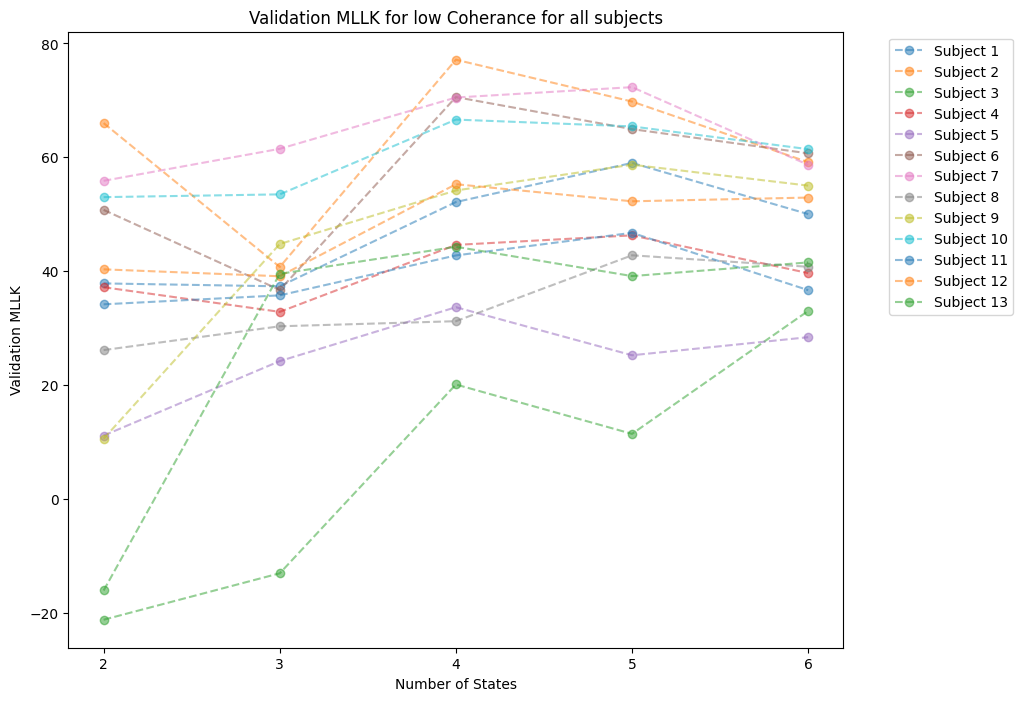

In [41]:
# plot the state-wise validation mllk for all subjects
plt.figure(figsize=(10, 8))

for coh_idx in range(1):
    for subj_idx in range(13):
        plt.plot(np.arange(2, 7), valid_mllk[coh_idx, subj_idx, :, :].mean(axis=-1), 'o--', alpha=0.5, label=f'Subject {subj_idx+1}')

plt.xlabel('Number of States')
plt.ylabel('Validation MLLK')
plt.title('Validation MLLK for low Coherance for all subjects')
plt.xticks(np.arange(2, 7))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

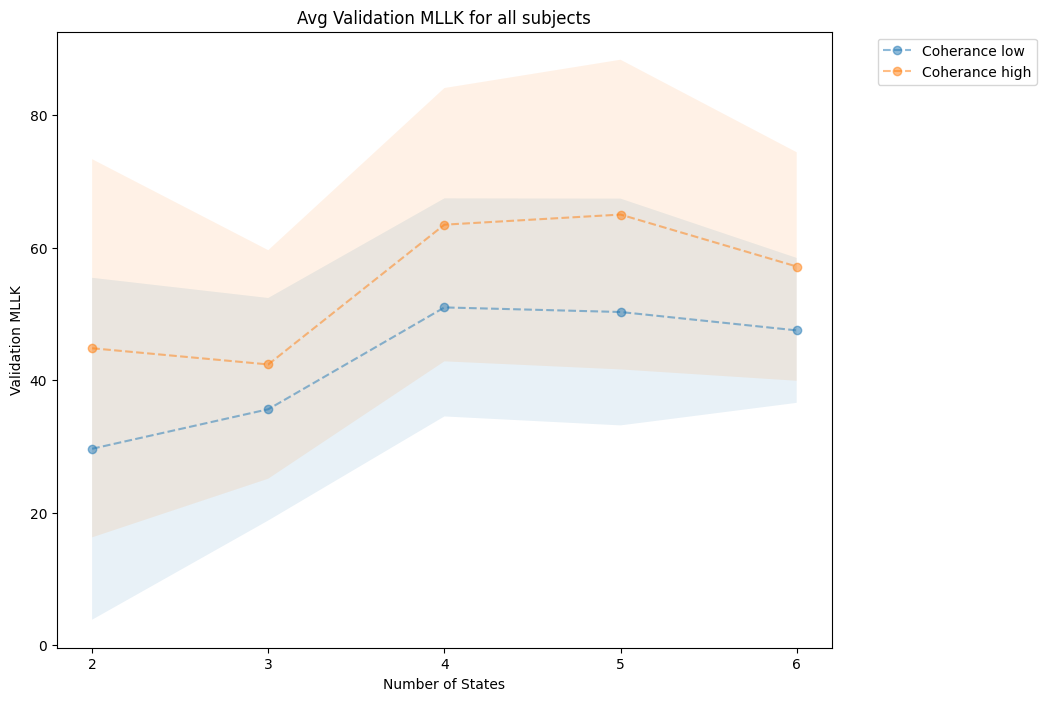

In [48]:
# plot the state-wise validation mllk for all subjects
plt.figure(figsize=(10, 8))

for coh_idx in range(0,2):
    plt.plot(np.arange(2, 7), valid_mllk[coh_idx, :, :, :].mean(axis=-1).mean(axis=0), 'o--', alpha=0.5, label=f'Coherance {"low" if coh_idx == 0 else "high"}')
    # now plot variance also
    plt.fill_between(np.arange(2, 7), valid_mllk[coh_idx, :, :, :].mean(axis=-1).mean(axis=0) - valid_mllk[coh_idx, :, :, :].mean(axis=-1).std(axis=0), valid_mllk[coh_idx, :, :, :].mean(axis=-1).mean(axis=0) + valid_mllk[coh_idx, :, :, :].mean(axis=-1).std(axis=0), alpha=0.1)

plt.xlabel('Number of States')
plt.ylabel('Validation MLLK')
plt.title('Avg Validation MLLK for all subjects')
plt.xticks(np.arange(2, 7))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

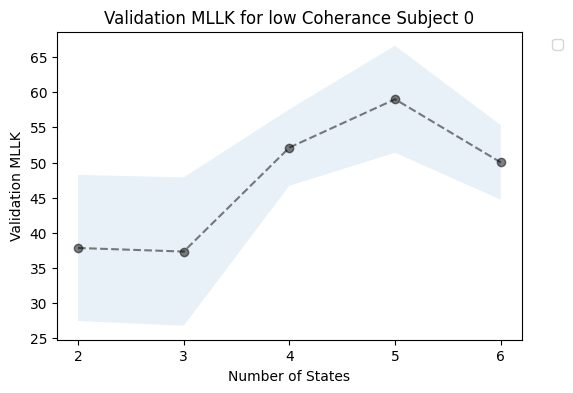

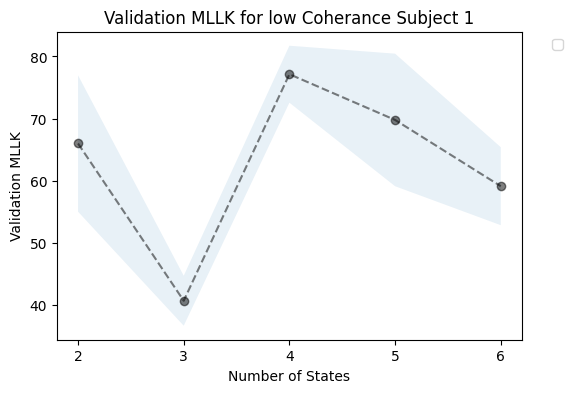

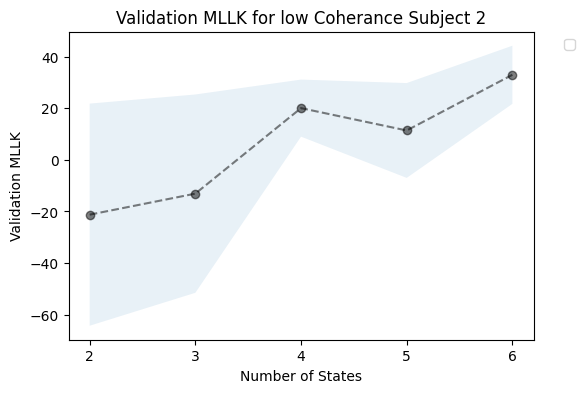

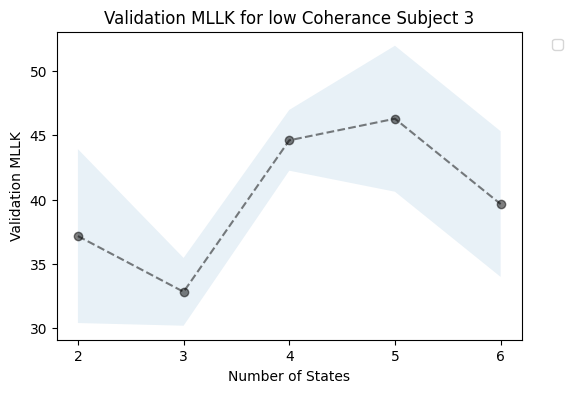

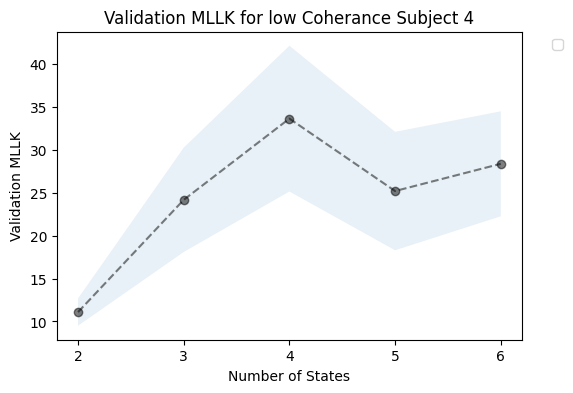

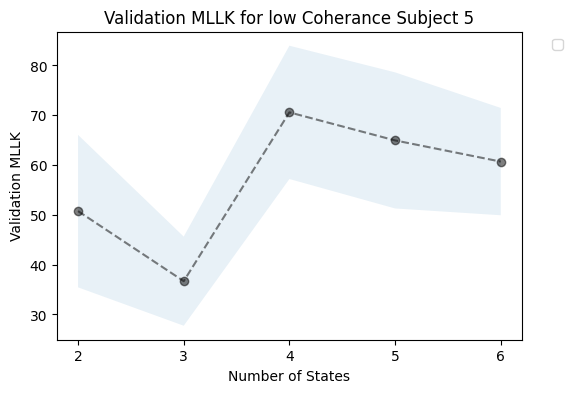

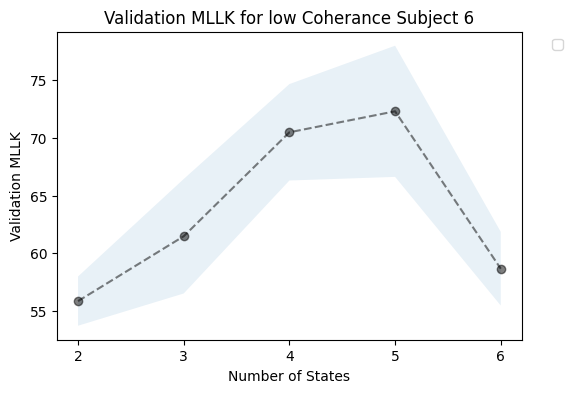

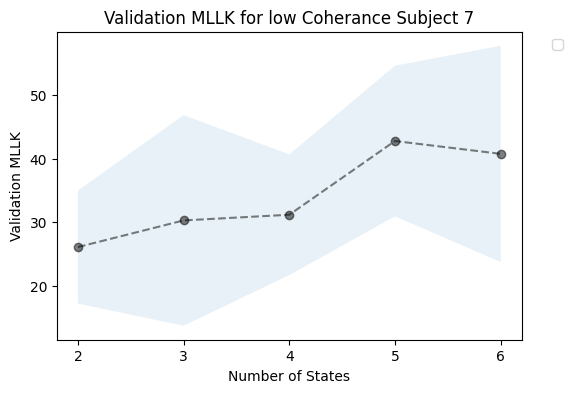

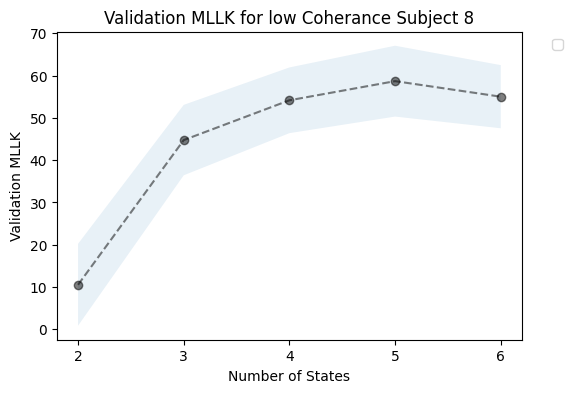

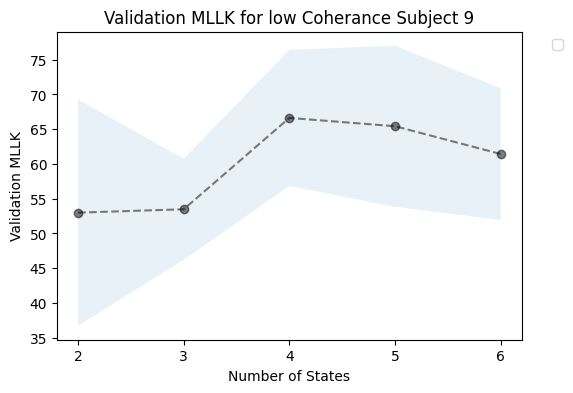

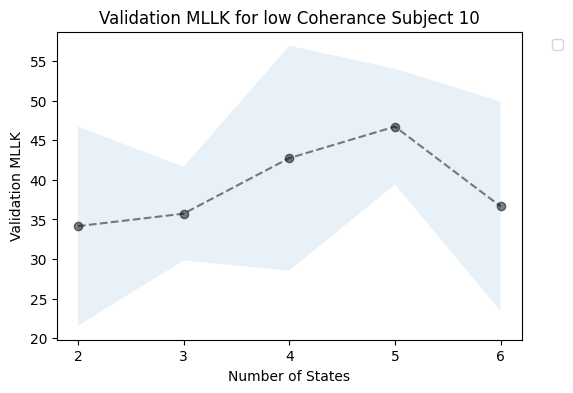

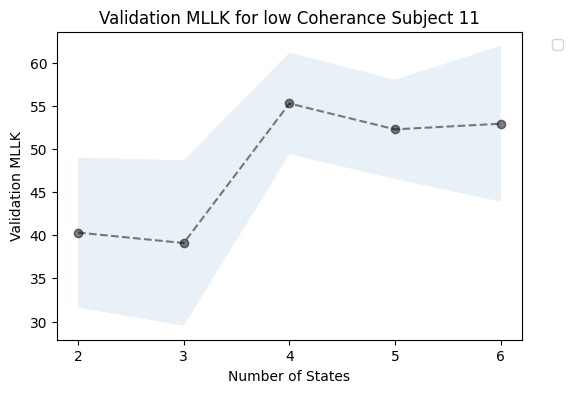

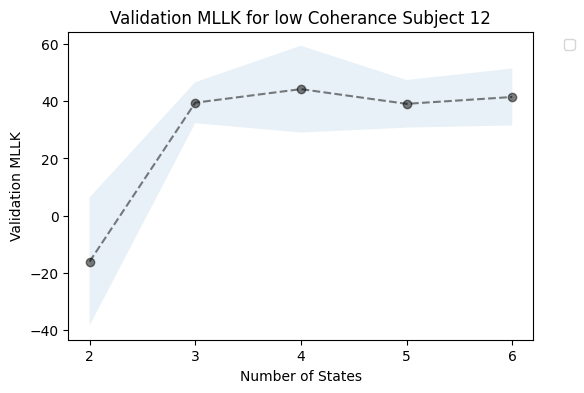

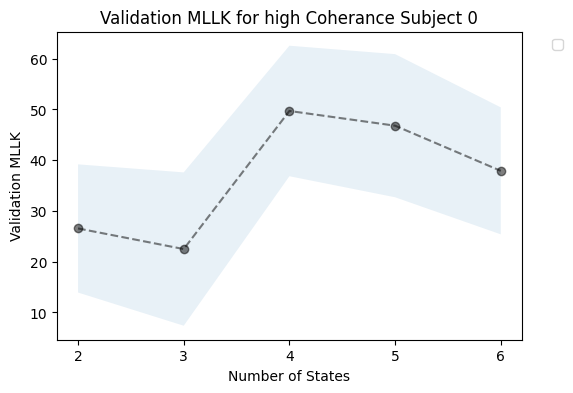

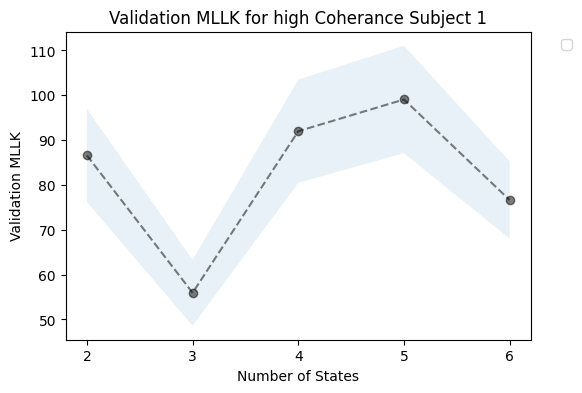

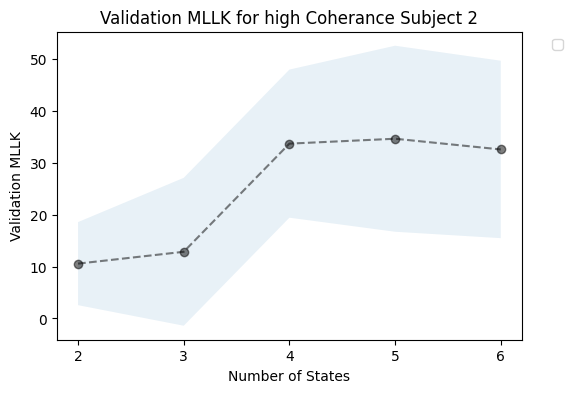

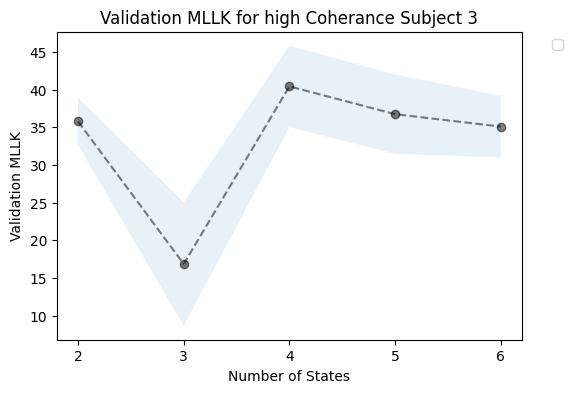

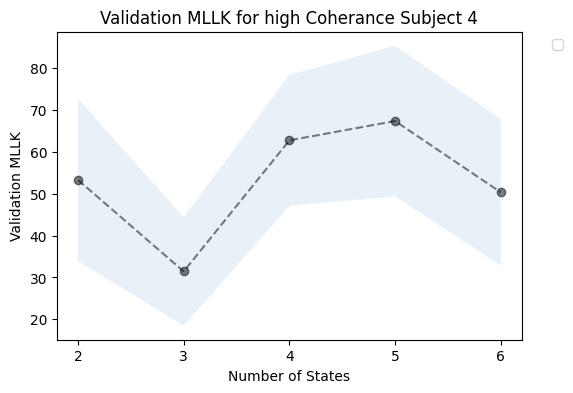

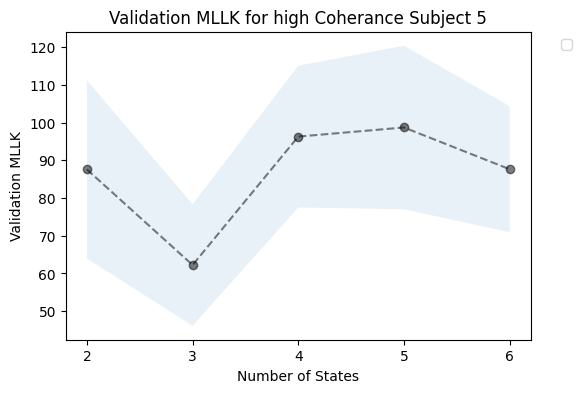

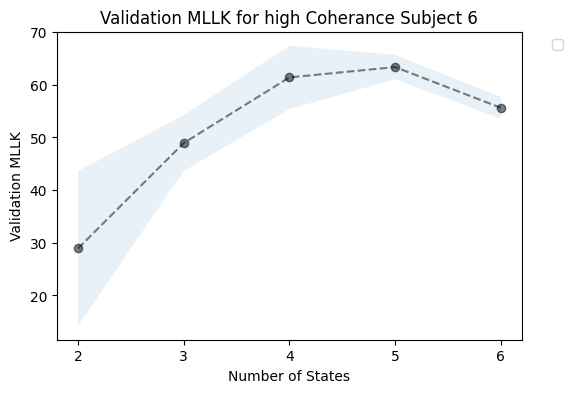

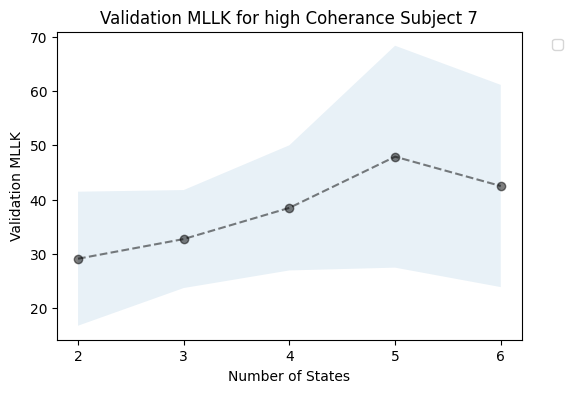

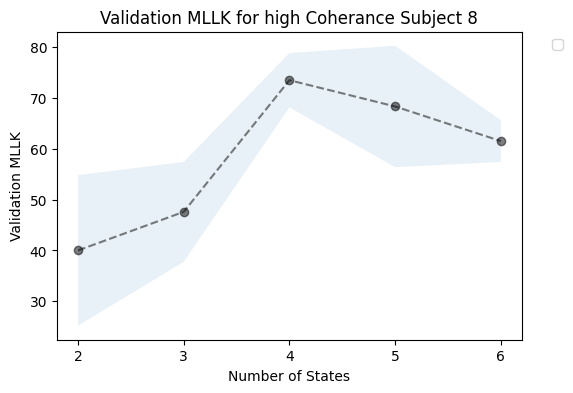

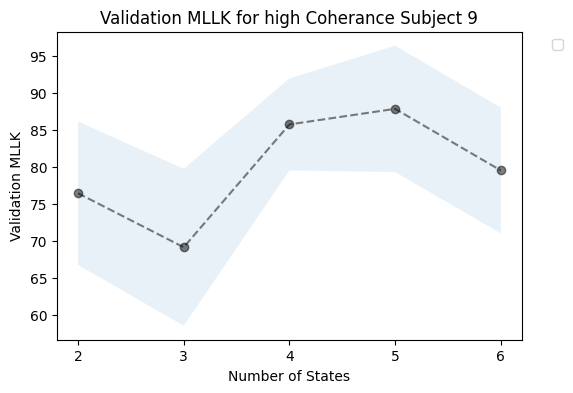

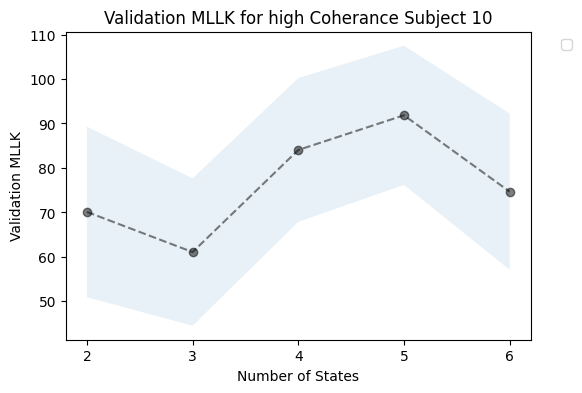

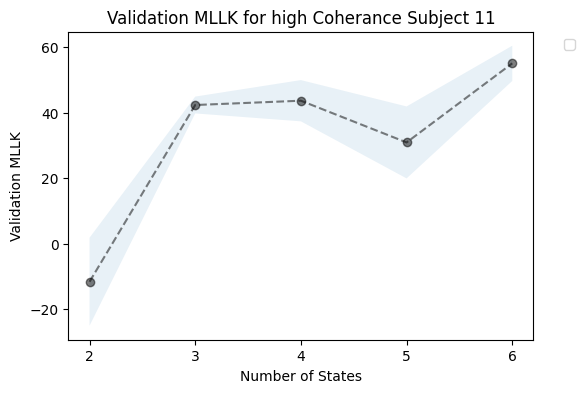

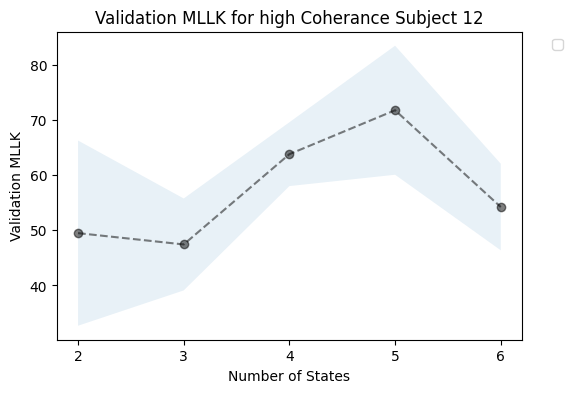

In [58]:
# plot the state-wise validation mllk for all subjects

for coh_idx in range(2):
    for subj_idx in range(13):
        plt.figure(figsize=(6, 4))

        plt.plot(np.arange(2, 7), valid_mllk[coh_idx, subj_idx, :, :].mean(axis=-1), 'o--', color = "k", alpha=0.5, label=f'')
        # put the variance
        plt.fill_between(np.arange(2, 7), valid_mllk[coh_idx, subj_idx, :, :].mean(axis=-1) - valid_mllk[coh_idx, subj_idx, :, :].std(axis=-1), valid_mllk[coh_idx, subj_idx, :, :].mean(axis=-1) + valid_mllk[coh_idx, subj_idx, :, :].std(axis=-1), alpha=0.1)

        plt.xlabel('Number of States')
        plt.ylabel('Validation MLLK')
        plt.title(f'Validation MLLK for {"low" if coh_idx == 0 else "high"} Coherance Subject {subj_idx}')
        plt.xticks(np.arange(2, 7))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.plot()

# Subject report plot

In [14]:
store.valid_mllk

array([44.53744507, 40.76024628, 45.91228104, 20.1193409 ])

In [ ]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from jax import jit
from jax import vmap
from jax.tree_util import tree_map, tree_leaves, tree_flatten, tree_unflatten
import jax
import jaxlib
from jaxtyping import Array, Int
from scipy.optimize import linear_sum_assignment
from typing import Optional
from jax.scipy.linalg import cho_factor, cho_solve

In [ ]:
def compute_state_overlap(
    z1: Int[Array, "num_timesteps"],
    z2: Int[Array, "num_timesteps"]
):
    """
    Compute a matrix describing the state-wise overlap between two state vectors
    ``z1`` and ``z2``.
    """
    assert z1.shape == z2.shape
    assert z1.min() >= 0 and z2.min() >= 0

    K = max(z1.max(), z2.max()) + 1

    overlap = jnp.sum(
        (z1[:, None] == jnp.arange(K))[:, :, None]
        & (z2[:, None] == jnp.arange(K))[:, None, :],
        axis=0,
    )
    return overlap


In [ ]:
from jaxtyping import Array, Int
from scipy.optimize import linear_sum_assignment

def find_permutation(
    z1: Int[Array, "num_timesteps"],
    z2: Int[Array, "num_timesteps"]
):
    """
    Find the permutation of the state labels in sequence ``z1`` so that they
    best align with the labels in ``z2``.

    Returns:
        permutation such that ``jnp.take(perm, z1)`` best aligns with ``z2``.
        Thus, ``len(perm) = min(z1.max(), z2.max()) + 1``.
    """
    overlap = compute_state_overlap(z1, z2)
    _, perm = linear_sum_assignment(-overlap)
    return perm
